-------------------------------------------------------------------------------------------------------------------------------
<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Iteso_logo.jpg" width="100" height="100"> 

# <font color='#797983'> **Factset Learning | Otoño 2021.**
### <font color='#1A2478'> **Instituto Tecnológico y de Estudios Superiores de Occidente**.
    
<img align="right" src="Logo_sociedad.png" width="125" height="100" />

**<font color='#797983'>Lecturers:** 
- Juan Pablo Ruíz.
- Bryan Juárez.
    
**<font color='#797983'>Date:** 
- October 6, 2021.
    
### <font color='#797983'> **Portfolio Analysis Module**.
-------------------------------------------------------------------------------------------------------------------------------

**Potential portfolio tickers.**

The tickers to analyze will be a random sample of $400$ tickers from the $\text{S&P500}$ index.

In [1]:
### Libraries to use.
import pandas as pd 
import numpy as np
import yfinance as yf
from datetime import datetime, date
from scipy.optimize import minimize
from CDIN import CDIN as eda
from yahoofinancials import YahooFinancials
import requests
import bs4 as bs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Get the tickers we're interested in. Let's take the random sample of 450 from S&P500.
np.random.seed(5555)

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
raw_tickers = []
tickers_adder = raw_tickers.append

for row in table.findAll('tr')[1:]:
    single_ticker = row.findAll('td')[0].text
    tickers_adder(single_ticker)

clean_tickers = [i.replace('\n', '') for i in raw_tickers]

tickers = pd.DataFrame(clean_tickers,
                       columns=['Stock']).sample(n=400)
tickers.head(10)

,Stock
104,CHTR
286,LDOS
228,HSIC
58,BKR
18,ALLE
495,WLTW
114,CFG
226,HCA
53,ADSK
497,XEL


**P/E ratio.**

Now In order to reduce the quantity of tickers that will become an input for the optimitazion algorithm, let's use the **P/E ratio** to filter our sample and get the $300$ stocks with the lowest ratio. This means we have the "cheapest" stocks available from the $\text{S&P500}$ index.

In [3]:
### Selected time period. 3 years of historical data.
start_date = '2018-10-01'
end_date = datetime.today().strftime('%Y-%m-%d')

### Make a list of all the available tickers.
tickers_list = tickers['Stock'].tolist()

### Let's substract the stocks info.
stocks_to_watch = tickers_list
yahoo_financials = YahooFinancials(stocks_to_watch)
daily_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, 'daily')

In [4]:
### Get the P/E ratio of the stocks.
PE_values = pd.DataFrame.from_dict(yahoo_financials.get_pe_ratio(), orient='index', columns=['P/E ratio'])
PE_values.index.name = 'Stocks'

PE_values.dropna(inplace=True)
PE_values.head(10)

,P/E ratio
Stocks,
CHTR,38.127907
LDOS,19.029297
HSIC,18.578186
ALLE,26.051130
WLTW,20.734080
CFG,10.774553
HCA,17.012701
ADSK,47.999320
XEL,21.313099


In [5]:
### Sorting values. Top 300 stocks with the lowest P/E ratio.
n_stocks = 300
best_stocks = PE_values.sort_values(by='P/E ratio')[0:n_stocks]

print('This is the top 10 cheapest stocks:')
best_stocks.head(10)

This is the top 10 cheapest stocks:


,P/E ratio
Stocks,
MHK,3.592119
OGN,4.858601
MPC,5.387811
BIO,5.460433
CINF,6.552315
AFL,6.803752
GS,6.977086
COO,7.104779
PHM,7.460780


**Historical data.**

Let's download the adjusted closes of the tickers of interest. In this case we'll take $3$ years of historical data since today (2018-10-01).

In [6]:
### Let´s define a function to get adjusted closes.
def get_adj_closes_yahoo(tickers: 'List of the tickers to download',
                         start_date = None,
                         end_date = None):
    
    # Download the data and take the adjusted close.
    closes = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    
    return closes

In case 'yfinance' library fails, we'll give an alternative method to download the stock prices. In this le's use 'yfinance'.

In [7]:
### Alternative stock downloader.
def alternative_prices_downloader(stocks: 'Stocks tickers, list type',
                                  daily_prices: 'Stock prices as a yahoo_financials dictionary'):
    prices_list = []
    adder = prices_list.append

    for i in stocks:
        series = pd.DataFrame(daily_prices[i]['prices']).set_index(['formatted_date']).rename_axis('Date')['adjclose']
        adder(series)

    final_df = pd.DataFrame(prices_list).T
    final_df.columns = stocks
    return final_df

In [8]:
## Downloading the data.
tickers_to_analyze = best_stocks.index.tolist()
closes = get_adj_closes_yahoo(tickers_to_analyze, start_date, end_date)
closes.head(10)

,A,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WHR,WLTW,WMT,WU,XEL,XLNX,YUM,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,69.717545,166.090332,55.043163,81.416893,70.668861,165.563538,275.489990,87.108345,141.333603,155.500000,...,107.688133,136.023193,89.454857,16.908318,43.436043,77.345497,85.801186,173.199997,45.300419,90.048920
2018-10-02,70.128456,164.915161,55.532413,80.756989,70.373283,165.220001,272.000000,87.014076,142.299332,153.919998,...,104.836784,137.126740,90.165573,16.801582,44.016792,77.567963,85.383690,168.990005,45.172478,90.215927
2018-10-03,70.558937,164.131729,56.208153,82.282471,68.685707,166.164688,270.510010,86.580376,142.130569,154.869995,...,103.856064,137.078735,89.142143,16.970581,43.454487,79.434860,85.174911,169.410004,46.406189,91.886040
2018-10-04,69.130539,162.280838,55.219971,80.422729,68.475937,163.989105,263.709991,84.845558,140.846054,152.100006,...,103.692612,136.906006,89.274788,16.543646,43.740250,79.550934,84.994614,165.199997,47.091595,89.469292
2018-10-05,68.778336,162.398331,54.323814,80.885536,68.247131,163.387970,263.220001,82.167923,141.568008,152.000000,...,101.268059,136.023193,88.421951,16.161184,44.588329,75.352859,85.402649,162.229996,46.762604,90.333801
2018-10-08,67.995636,164.875992,54.197868,81.254044,68.113632,162.118851,254.690002,81.536217,139.983444,146.210007,...,102.212448,137.030792,89.729645,16.027769,44.966267,74.936905,86.009964,158.500000,47.603363,89.862267
2018-10-09,67.907593,165.394989,54.948700,81.048370,67.970619,161.069244,254.160004,81.800209,140.771027,142.860001,...,96.527931,136.829254,91.994453,16.161184,45.178280,75.111023,86.522377,157.380005,47.219536,90.923279
2018-10-10,65.226898,159.793396,52.403141,79.771416,65.710976,154.332565,237.910004,79.103722,132.932693,133.500000,...,95.320198,133.806534,90.743622,15.796517,45.021572,72.044685,84.643524,149.580002,46.442749,88.054588
2018-10-11,63.485420,157.707489,51.940525,77.731689,65.196098,148.855469,238.589996,78.886841,129.557358,130.889999,...,94.757187,130.572647,88.999992,15.716467,43.896957,71.570694,82.622322,151.000000,44.943996,85.470825


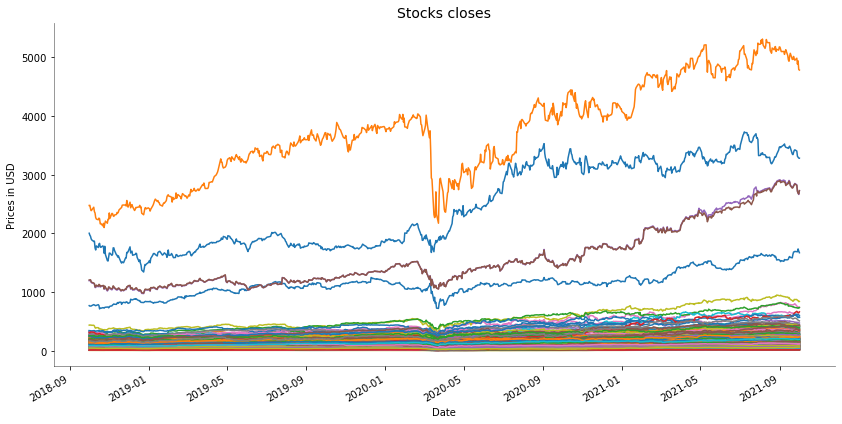

In [9]:
### Let's visualize our adjusted close prices in a graphic.
closes.plot(figsize=[14,7], legend=None)
plt.ylabel('Prices in USD')
plt.title('Stocks closes', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

In [10]:
### Get the tickers with missing values, this tickers won't be useful for us.
missing_values = eda.dqr(closes)['missing_values']

missing_prices = {j:i for i,j in zip(missing_values, missing_values.index) if i > 0}

print('The tickers with missing values are: ')
print(f'We have a total of {len(missing_prices)} stocks with missing values')
missing_prices

The tickers with missing values are: 
We have a total of 4 stocks with missing values


{'CARR': 368, 'DOW': 116, 'FOX': 111, 'OGN': 659}

As we can see we have $3$ tickers with missing prices, this means we can't work with them because that lack of information will affect the optimitazion. Let's drop them.

In [11]:
### Let's drop the tickers that won't be useful.
tickers_to_drop = [i for i in missing_prices.keys()]

closes_final = closes.drop(tickers_to_drop, axis=1)
closes_final.head(10)

,A,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WHR,WLTW,WMT,WU,XEL,XLNX,YUM,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,69.717545,166.090332,55.043163,81.416893,70.668861,165.563538,275.489990,87.108345,141.333603,155.500000,...,107.688133,136.023193,89.454857,16.908318,43.436043,77.345497,85.801186,173.199997,45.300419,90.048920
2018-10-02,70.128456,164.915161,55.532413,80.756989,70.373283,165.220001,272.000000,87.014076,142.299332,153.919998,...,104.836784,137.126740,90.165573,16.801582,44.016792,77.567963,85.383690,168.990005,45.172478,90.215927
2018-10-03,70.558937,164.131729,56.208153,82.282471,68.685707,166.164688,270.510010,86.580376,142.130569,154.869995,...,103.856064,137.078735,89.142143,16.970581,43.454487,79.434860,85.174911,169.410004,46.406189,91.886040
2018-10-04,69.130539,162.280838,55.219971,80.422729,68.475937,163.989105,263.709991,84.845558,140.846054,152.100006,...,103.692612,136.906006,89.274788,16.543646,43.740250,79.550934,84.994614,165.199997,47.091595,89.469292
2018-10-05,68.778336,162.398331,54.323814,80.885536,68.247131,163.387970,263.220001,82.167923,141.568008,152.000000,...,101.268059,136.023193,88.421951,16.161184,44.588329,75.352859,85.402649,162.229996,46.762604,90.333801
2018-10-08,67.995636,164.875992,54.197868,81.254044,68.113632,162.118851,254.690002,81.536217,139.983444,146.210007,...,102.212448,137.030792,89.729645,16.027769,44.966267,74.936905,86.009964,158.500000,47.603363,89.862267
2018-10-09,67.907593,165.394989,54.948700,81.048370,67.970619,161.069244,254.160004,81.800209,140.771027,142.860001,...,96.527931,136.829254,91.994453,16.161184,45.178280,75.111023,86.522377,157.380005,47.219536,90.923279
2018-10-10,65.226898,159.793396,52.403141,79.771416,65.710976,154.332565,237.910004,79.103722,132.932693,133.500000,...,95.320198,133.806534,90.743622,15.796517,45.021572,72.044685,84.643524,149.580002,46.442749,88.054588
2018-10-11,63.485420,157.707489,51.940525,77.731689,65.196098,148.855469,238.589996,78.886841,129.557358,130.889999,...,94.757187,130.572647,88.999992,15.716467,43.896957,71.570694,82.622322,151.000000,44.943996,85.470825


In [12]:
### Let´s calculate the returns.
ret = closes_final.pct_change().dropna()
ret.head(10)

,A,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WHR,WLTW,WMT,WU,XEL,XLNX,YUM,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-02,0.005894,-0.007075,0.008888,-0.008105,-0.004183,-0.002075,-0.012668,-0.001082,0.006833,-0.010161,...,-0.026478,0.008113,0.007945,-0.006313,0.013370,0.002876,-0.004866,-0.024307,-0.002824,0.001855
2018-10-03,0.006138,-0.004751,0.012168,0.018890,-0.023980,0.005718,-0.005478,-0.004984,-0.001186,0.006172,...,-0.009355,-0.000350,-0.011351,0.010059,-0.012775,0.024068,-0.002445,0.002485,0.027311,0.018512
2018-10-04,-0.020244,-0.011277,-0.017581,-0.022602,-0.003054,-0.013093,-0.025138,-0.020037,-0.009038,-0.017886,...,-0.001574,-0.001260,0.001488,-0.025157,0.006576,0.001461,-0.002117,-0.024851,0.014770,-0.026302
2018-10-05,-0.005095,0.000724,-0.016229,0.005755,-0.003341,-0.003666,-0.001858,-0.031559,0.005126,-0.000658,...,-0.023382,-0.006448,-0.009553,-0.023118,0.019389,-0.052772,0.004801,-0.017978,-0.006986,0.009663
2018-10-08,-0.011380,0.015257,-0.002318,0.004556,-0.001956,-0.007768,-0.032406,-0.007688,-0.011193,-0.038092,...,0.009326,0.007408,0.014789,-0.008255,0.008476,-0.005520,0.007111,-0.022992,0.017979,-0.005220
2018-10-09,-0.001295,0.003148,0.013854,-0.002531,-0.002100,-0.006474,-0.002081,0.003238,0.005626,-0.022912,...,-0.055615,-0.001471,0.025240,0.008324,0.004715,0.002324,0.005958,-0.007066,-0.008063,0.011807
2018-10-10,-0.039476,-0.033868,-0.046326,-0.015755,-0.033244,-0.041825,-0.063936,-0.032964,-0.055681,-0.065519,...,-0.012512,-0.022091,-0.013597,-0.022564,-0.003469,-0.040824,-0.021715,-0.049562,-0.016451,-0.031551
2018-10-11,-0.026699,-0.013054,-0.008828,-0.025570,-0.007835,-0.035489,0.002858,-0.002742,-0.025391,-0.019551,...,-0.005907,-0.024168,-0.019215,-0.005068,-0.024979,-0.006579,-0.023879,0.009493,-0.032271,-0.029343
2018-10-12,0.020804,0.025335,0.035719,0.010586,0.018062,0.022051,0.043086,0.005976,0.018382,0.055696,...,-0.004791,0.009039,0.009476,0.013582,0.000630,0.028788,0.011255,0.044437,-0.019520,0.021839


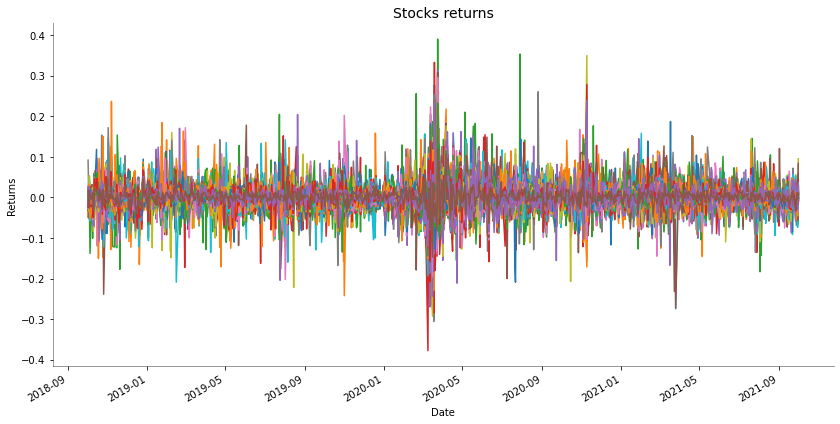

In [13]:
### Let's visualize our returns in a graphic
ret.plot(figsize=[14,7], legend=None)
plt.ylabel('Returns')
plt.title('Stocks returns', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

**Minimal Variance Portfolio.**

Now we're trying to get the minimal variace portfolio, this portfolio as it own name says has particular characteristics, the minimal variace in the expected return / volatility space.

In [14]:
### Correlation matrix.
corr = ret.corr()
corr.head(10)

,A,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WHR,WLTW,WMT,WU,XEL,XLNX,YUM,ZBRA,ZION,ZTS
A,1.000000,0.389350,0.577379,0.480068,0.641856,0.649883,0.611004,0.616082,0.588159,0.610056,...,0.470749,0.475395,0.436123,0.471132,0.430673,0.517558,0.421105,0.597546,0.383786,0.632577
AAP,0.389350,1.000000,0.369659,0.353536,0.332119,0.472532,0.352180,0.424610,0.510973,0.371828,...,0.456946,0.406118,0.340735,0.436834,0.443633,0.279758,0.455397,0.376885,0.425074,0.439676
AAPL,0.577379,0.369659,1.000000,0.427719,0.561624,0.634978,0.707473,0.608077,0.584472,0.630418,...,0.475711,0.436393,0.446048,0.436795,0.414032,0.529617,0.432055,0.570465,0.279338,0.593814
ABBV,0.480068,0.353536,0.427719,1.000000,0.501976,0.495370,0.450093,0.397893,0.482286,0.434476,...,0.369218,0.364726,0.300217,0.302336,0.348204,0.290969,0.348593,0.398071,0.316171,0.497971
ABT,0.641856,0.332119,0.561624,0.501976,1.000000,0.619238,0.565587,0.516838,0.588851,0.494726,...,0.462230,0.488020,0.449938,0.392270,0.532324,0.433123,0.430016,0.500179,0.252120,0.647134
ACN,0.649883,0.472532,0.634978,0.495370,0.619238,1.000000,0.667354,0.619100,0.747702,0.651496,...,0.541547,0.604419,0.427687,0.552850,0.510602,0.489530,0.589485,0.595505,0.461368,0.664217
ADBE,0.611004,0.352180,0.707473,0.450093,0.565587,0.667354,1.000000,0.629246,0.595455,0.755336,...,0.368761,0.425105,0.451273,0.372442,0.381802,0.559051,0.364608,0.578812,0.176766,0.590860
ADI,0.616082,0.424610,0.608077,0.397893,0.516838,0.619100,0.629246,1.000000,0.589021,0.632895,...,0.517095,0.484725,0.378309,0.451485,0.364715,0.689513,0.447389,0.582560,0.428670,0.530469
ADP,0.588159,0.510973,0.584472,0.482286,0.588851,0.747702,0.595455,0.589021,1.000000,0.591598,...,0.529901,0.558734,0.407757,0.527746,0.575717,0.451898,0.573760,0.545692,0.472152,0.642875
ADSK,0.610056,0.371828,0.630418,0.434476,0.494726,0.651496,0.755336,0.632895,0.591598,1.000000,...,0.414247,0.434624,0.336610,0.392599,0.317687,0.570751,0.423304,0.597322,0.329348,0.544009


In [15]:
### Let's calculate our anual returns and our anual std. deviation for every asset.
annual = pd.DataFrame({'$E[r]$':ret.mean()*252, '$\sigma$':ret.std()*np.sqrt(252)})
annual = annual.T
annual

,A,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WHR,WLTW,WMT,WU,XEL,XLNX,YUM,ZBRA,ZION,ZTS
$E[r]$,0.310823,0.137292,0.380689,0.14106,0.210179,0.265829,0.314157,0.288672,0.166589,0.281074,...,0.310413,0.235666,0.167687,0.110094,0.156607,0.323911,0.163908,0.444225,0.203122,0.301172
$\sigma$,0.290219,0.350885,0.354927,0.29266,0.288195,0.287396,0.367651,0.375937,0.307341,0.400027,...,0.439333,0.300532,0.226786,0.301177,0.265100,0.446587,0.293731,0.408570,0.426781,0.287606


**Risk free rate.**

For the purpose of this portfolio analysis, let's take the one year rate (we use it for the day 10/01/21). You can consult it from Factset.

[U.S Government Yields](https://my.apps.factset.com/navigator/markets/government-yields)

In [16]:
### Risk free rate.
rf = 0.0775/100

In [17]:
### From the mean variance dataframe called annual. 
# We create a matrix which the main diagonal is going to be the std. deviation of the assets.
# This will help us to calculate the std. deviation of our portfolio.
S = np.diag(annual.loc['$\sigma$'])

In [18]:
### Building the parameters.
# 1. Variance-Covariance matrix Sigma its equal to:
# Sigma = S.dot(corr).dot(S)
Sigma = S.dot(corr).dot(S)

# 3. Eind: expected returns of individual assets
Eind = annual.loc['$E[r]$']

In [19]:
### Building the minimun variance frontier.
# Objective function.
def var(w,Sigma):
    
    ''' Sigma is the variance-covariance matrix'''
    ''' w is a vector that contains the weights of each asset in the portfolio'''
    
    return w.T.dot(Sigma).dot(w)

In [20]:
### Initial values. Let's start from 1%.
w0 = np.ones(len(Eind))/len(Eind)

### Variables limits. Let's define a maximum of 17% weight
bnd = ((0,0.17),)*len(Eind)

### Restrictions.
cons = ({'type':'eq','fun': lambda w: np.sum(w)-1},)

In [21]:
### Optimization.
# Minimal Variance Portfolio.
minvar = minimize(fun=var,x0=w0,args=(Sigma,),bounds=bnd,constraints=cons)

In [22]:
### Weights.
w_minvar = minvar.x

### Portfolio risk.
s_minvar = (var(w_minvar,Sigma))**(0.5)

### Expected return.
E_minvar = Eind.dot(w_minvar)

### Sharpe ratio.
RS_minvar=(E_minvar-rf)/s_minvar

minvar_data = pd.DataFrame({'$\sigma$':s_minvar, '$E[r]$':E_minvar,'Sharpe ratio':RS_minvar},
                            index=['Minimal Variance Portfolio'])
minvar_data.T

,Minimal Variance Portfolio
$\sigma$,0.150031
$E[r]$,0.144341
Sharpe ratio,0.956911


**Efficient Mean Variance Portfolio.**

In [23]:
### Objective function.
# Now the optimization is respect to the sharpe ratio.
def menos_RS(w,Eind,Sigma,rf):
    
    ''' w is a vector that contain the weights of each asset in the portfolio '''
    ''' Eind expected returns of individual assets '''
    ''' Sigma: Variace-Covariance Matrix '''
    ''' rf: risk free rate '''
    
    return -((Eind.T.dot(w))-rf)/((w.T.dot(Sigma).dot(w))**(0.5))

In [24]:
### Portfolio EMV.
EMV = minimize(fun=menos_RS,x0=w0,args=(Eind,Sigma,rf,),bounds=bnd,constraints=cons)

In [25]:
### Weights.
W_EMV = EMV.x

### Portfolio Expected return.
E_EMV = Eind.T.dot(W_EMV)

### Portfolio risk.
S_EMV = var(W_EMV,Sigma)**0.5

### Sharpe ratio.
RS_EMV = (E_EMV-rf)/S_EMV

P_EMV = pd.DataFrame({'$E[r]$':E_EMV, '$\sigma$':S_EMV,'Sharpe ratio':RS_EMV},index=['EMV Portfolio'])
P_EMV.T

,EMV Portfolio
$E[r]$,0.423431
$\sigma$,0.211064
Sharpe ratio,2.002501


**Building the frontier.**

Now we're looking for the minimal variance frontier, let's build it.

In [26]:
### Covariance between the portfolios.
cov_EMV_minvar = W_EMV.dot(Sigma).dot(w_minvar)
print(f'The covariance between portfolios: {cov_EMV_minvar*100}%')

The covariance between portfolios: 2.5579657577138435%


In [27]:
### Correlation between portfolios.
corr_EMV_minvar = cov_EMV_minvar/(S_EMV*s_minvar)
print(f'The correlation between portfolios: {corr_EMV_minvar*100}%')

The correlation between portfolios: 80.77932425581984%


In [28]:
### Portfolios dataframe. 
# Vector of weights.
wp = np.linspace(0,1,1000)

fron_min_var = pd.DataFrame({'W':wp,'W(minvar)':1-wp,'$E[r]$':E_EMV*wp+(1-wp)*E_minvar,
                             '$\sigma$':(((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5),
                             'SR':((E_EMV*wp+(1-wp)*E_minvar)-rf)/((((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5))})
fron_min_var

,W,W(minvar),$E[r]$,$\sigma$,SR
0,0.000000,1.000000,0.144341,0.150031,0.956911
1,0.001001,0.998999,0.144620,0.150051,0.958642
2,0.002002,0.997998,0.144900,0.150072,0.960371
3,0.003003,0.996997,0.145179,0.150093,0.962100
4,0.004004,0.995996,0.145458,0.150113,0.963827
...,...,...,...,...,...
995,0.995996,0.004004,0.422314,0.210705,2.000615
996,0.996997,0.003003,0.422593,0.210794,2.001088
997,0.997998,0.002002,0.422872,0.210884,2.001560
998,0.998999,0.001001,0.423152,0.210974,2.002031


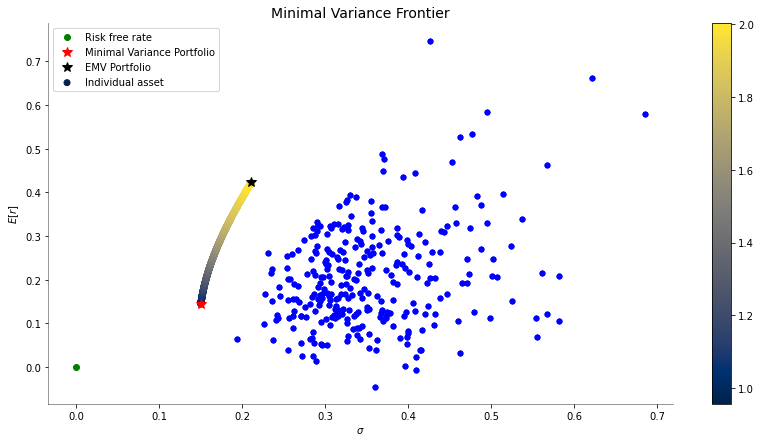

In [29]:
### Plotting the portfolios.
plt.figure(figsize=(14,7))
plt.xlabel('$\sigma$')
plt.ylabel('$E[r]$')

# Free risk rate.
plt.plot(0,rf,'og',label='Risk free rate')

# Minvar portfolio.
plt.plot(s_minvar,E_minvar,'*r',ms=10, label='Minimal Variance Portfolio')

# EMV portfolio.
plt.plot(S_EMV,E_EMV,'*k',ms=10, label='EMV Portfolio')

# Assets.
for i in range(len(annual)):
    plt.plot(annual.loc['$\sigma$'],annual.loc['$E[r]$'],'ob',ms=5)
    
plt.scatter(fron_min_var['$\sigma$'],fron_min_var['$E[r]$'],c=fron_min_var['SR'],cmap='cividis',label='Individual asset')
plt.colorbar()
plt.legend(loc='best')
plt.title('Minimal Variance Frontier', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

**Capital Asignation Line.**

With the analysis that we previously developed the captial asignation line will give us the optimal portfolio depending on our risk aversion coefficient, the weightins that this process returns includes the risk free rate as a possible investment. For the purpose of this tutorial we´re interested in the assets that aren´t risk free, that´s why the final output of this document will be a dataframe with the name of the assets and their respective weights on the particular portfolio.

In order to get the optimal asignation of capital, we need to know our risk aversion coefficent. [You can check yours here](https://www.wsj.com/articles/check-your-tolerance-for-investment-risk-now-before-markets-sag-1405619939)

For practical reasons, let's assume we have risk aversion coefficient of $8$.

In [30]:
### Let's build our CAL.
LAC = pd.DataFrame({'w(EMV)': wp,
                    'w(rf)': 1 - wp,
                    '$E[r]$': wp * E_EMV + (1 - wp) * rf,
                    '$\sigma$': wp * S_EMV
                   })

LAC['RS'] = (LAC['$E[r]$'] - rf) / LAC['$\sigma$']
LAC.head()

,w(EMV),w(rf),$E[r]$,$\sigma$,RS
0,0.000000,1.000000,0.000775,0.000000,NaN
1,0.001001,0.998999,0.001198,0.000211,2.002501
2,0.002002,0.997998,0.001621,0.000423,2.002501
3,0.003003,0.996997,0.002044,0.000634,2.002501
4,0.004004,0.995996,0.002467,0.000845,2.002501


In [31]:
### Now let´s see how much invest in our assets portfolio and how much for the risk free rate.
gamma = 8
w_client = (E_EMV - rf) / (gamma * S_EMV**2)

# Dataframe
asignation_C = pd.DataFrame({'w(EMV)': w_client*100,
                             'w(rf)': (1 - w_client)*100,
                             'Gamma': gamma},
                             index = ['Capital Asignation in %'])
asignation_C

,w(EMV),w(rf),Gamma
Capital Asignation in %,118.59557,-18.59557,8


In [32]:
### Results.
print(f'The optimal investment in our EMV portfolio is: {w_client*100}%')
print(f'The optimal investment in our risk free rate is: {(1-w_client)*100}%')

The optimal investment in our EMV portfolio is: 118.5955703305486%
The optimal investment in our risk free rate is: -18.595570330548593%


Now let´s see the particular weights in our EMV portfolio.

In [33]:
### Let's get the weigths and their respective asset.
tickers_final = closes_final.columns.tolist()
EMV_port = {i: EMV.x[j]*100 for i,j in zip(tickers_final, range(len(tickers_final)))}
EMV_df_final = pd.DataFrame.from_dict(EMV_port, orient='index', columns=['Weights in %'])
EMV_df_final.index.name = 'Stocks'

print('This is the top 10 assets position:')
EMV_df_final.sort_values(by=['Weights in %'], ascending=False).head(10)

This is the top 10 assets position:


,Weights in %
Stocks,
GNRC,17.000000
EXR,14.983378
TGT,12.841000
PWR,12.165607
NLOK,10.260340
LLY,8.511133
MKTX,5.135337
DPZ,5.068850
KR,4.996229


This is the top 10 positions:


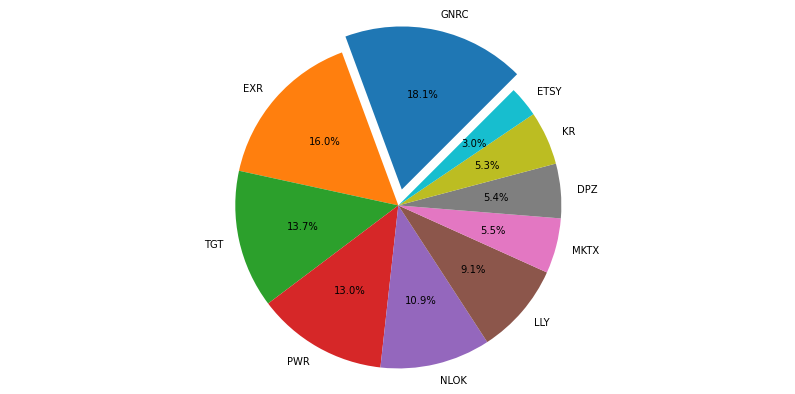

In [34]:
### Let's plot a pie chart to visualize the portfolio.
EMV_10 = EMV_df_final.sort_values(by=['Weights in %'], ascending=False).head(10)
labels_portfolio = EMV_10.T.columns.tolist()
sizes_portfolio = EMV_10.T.values.flatten().tolist()
explode_portfolio = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 

fig1_emv, ax1_emv = plt.subplots(figsize=[14,7])
ax1_emv.pie(sizes_portfolio, explode=explode_portfolio, labels=labels_portfolio, autopct='%1.1f%%',
            shadow=False, startangle=45, normalize=True)

ax1_emv.axis('equal')

print('This is the top 10 positions:')
plt.show()

In [35]:
### Final product of the document. This command will export a csv file on your repository carpet.
EMV_df_final.to_csv('Portfolio_weights.csv')

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Sociedad de Alumnos de Ingeniería Financiera.
</footer>